<h1 style="color:#361485"><strong>For better visualizations experience check this notebook at: </strong>
<a href='https://www.kaggle.com/code/mahmoudelhusseni/university/notebook'>
<img src='https://img.shields.io/static/v1?style=for-the-badge&message=Kaggle&color=222222&logo=Kaggle&logoColor=20BEFF&label=' alt='Kaggle'></img></a></h1>

<h1 style="color:#069974">Contents</h1>

* [1. Notebook Description](#NB_desc)<br>
* [2. Setting up our Enviroment & Explore dataset](#setting_env)<br>
* [3. Data Engineering](#dataeng)
    * Store same data categories from different file formats in the same table.
    * Draw ERD, Schema and join tables together.

* [4. Data Transforming](#trasforming)<br>
    * 1. [Handling Nulls.](#nulls)
    * 3. [Outliers.](#outliers)
* [5. Exploratory Data Analysis](#EDA)<br>
    * [Show any student's performance over all semsters](#1)
    * [Which is the semster that have the largest marks average?](#2)
    * [Is there some papers more to related to each other?](#3) <!--Heatmap of correlation-->
    * [Which are the top 10 attractive departments?](#4) <!--Bar chart-->
    * [Distribution of students in each departmentDistribution of students in each department](#8)
    * [Does number of students in department depend on average marks of these students?](#5) <!--Bar chart-->
    * [Does some departments are more similiar to each others than others?](#6)
    * [Time Series Analysis](#7)
    
* [6. Feature Engineering](#FE)<br>
* [7. Model Training](#modeling)<br>

<a id='NB_desc'></a>
<h1 style="text-align:left; background-color:#246361; color:#DDDBC0; padding:14px; border-radius:10px; margin:15px">
    1 <font color='#2F4240'><strong>|</strong> </font>Notebook Description</h1>

> <font size=3>The motivation behind creation this dataset is to analyse the performance of professors and students. The dataset is aimed towards recording the journey of students in a particular course, right from his/her admission till last of his/her course. of-course, This is the initial version. We will keep adding other tables and data fields to this. Enjoy Data Science.<br>

> <font size=3> The dataset contains the information of an imaginary institute. Information about its departments, Professors, Student Counselling, Coursers offered, course student selected to get admission and student performance in different examinations. </font>

<font size=3>For more information, check dataset at [Kaggle](https://www.kaggle.com/datasets/ananta/student-performance-dataset?select=Student_Counceling_Information.csv)</font>
    
<h2 style="color:#069974">In this Notebook: </h2>

- I am going to Extract data from multiple files, join them together,
- then I will preprocess this data to make it ready for upcoming procedures,
- after that I will do some analysis and visulaization on the data in order to extract some valuable insights, 
- Find if I can extract more informations from this data, 
- build machine learning model to predict `Total marks of students`.

<a id='setting_env'></a>
<h1 style="text-align:left; background-color:#246361; color:#DDDBC0; padding:14px; border-radius:10px; margin:15px">
    2 <font color='#2F4240'><strong>|</strong> </font>Setting up our Enviroment & Explore dataset</h1>

In [1]:
!pip install sas7bdat

  Preparing metadata (setup.py) ... - done
  Created wheel for sas7bdat: filename=sas7bdat-2.2.3-py3-none-any.whl size=16309 sha256=5053e20d2636a3628525fa0ebd39be33b81b6e694beccf55ae8c43134bbd7ca4
  Stored in directory: /root/.cache/pip/wheels/69/dd/ca/1fd7bf96640d87457056b763e015e20d8e566041bd3273d966
Successfully built sas7bdat


In [2]:
import os 
import gc
import time
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt

import seaborn as sns
import missingno
from termcolor import colored
from tqdm import tqdm
import ipywidgets as widgets

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sas7bdat import SAS7BDAT

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.dataloader import default_collate


# configurations
warnings.simplefilter('ignore')
SEPARATOR = colored(90*'#', 'magenta')
plt.style.use('ggplot')
sns.set_palette('dark')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = [30, 20]
LRSchedules = [1, 1e-2]
BATCH_SIZE = 128

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
MAIN_DIRECTORY = '../input/student-performance-dataset'

files = []
for file in os.listdir(MAIN_DIRECTORY):
    files.append(file)
    
sorted_files = sorted(files, key=lambda x : x[-4:])
colors = ['red', 'blue', 'green', 'magenta']


for i in range(len(files)//4):
    print(colored(sorted(sorted_files[i*4:(i+1)*4]), colors[i]))

['Department_Information.csv', 'Employee_Information.csv', 'Student_Counceling_Information.csv', 'Student_Performance_Data.csv']
['Department_Information.txt', 'Employee_Information.txt', 'Student_Counceling_Information.txt', 'Student_Performance_Data.txt']
['department_information.sas7bdat', 'employee_information.sas7bdat', 'student_counceling_information.sas7bdat', 'student_performance_data.sas7bdat']
['Employee_Information.xlsx', 'Student_Counceling_Information.xlsx', 'Student_Performance_Data.xlsx', 'Student_Performance_Data_Wide_Version.xlsx']


<a id='dataeng'></a>
<h1 style="text-align:left; background-color:#246361; color:#DDDBC0; padding:14px; border-radius:10px; margin:15px">
    3 <font color='#2F4240'><strong>|</strong> </font>Data Engineering</h1>

<h2 style="color:#069974">Note: </h2>

#### There are four formats of files `.csv`,  `.txt`, `.sas7bdat`, `.xlsx` , each having the same names, we need to find if all have the same information or not.

In [4]:
all_files = {}

for file in tqdm(os.listdir(MAIN_DIRECTORY)):
    if file[-4:] == '.csv':
        all_files[file] = pd.read_csv(os.path.join(MAIN_DIRECTORY, file))
    elif file[-4:] == '.txt':
        all_files[file] = pd.read_csv(os.path.join(MAIN_DIRECTORY, file), sep='|')
    elif file[-4:] == 'xlsx':
        all_files[file] = pd.read_excel(os.path.join(MAIN_DIRECTORY, file))
    elif file[-8:] == 'sas7bdat': 
        all_files[file] = SAS7BDAT(os.path.join(MAIN_DIRECTORY, file)).to_data_frame()
    else:
        print("Not supported file format :(")
        
gc.collect()

 76%|███████▋  | 13/17 [00:29<00:05,  1.49s/it][employee_information.sas7bdat] header length 131072 != 8192
[student_counceling_information.sas7bdat] header length 131072 != 8192
100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


56

In [5]:
file_cat = ['employee', 'department', 'counceling', 'performance']
employee = pd.DataFrame()
department = pd.DataFrame()
student = pd.DataFrame()
performance = pd.DataFrame()

for file in all_files:
    if 'employee' in file.lower():
        employee = pd.concat([employee, all_files[file]])
        
for file in all_files:
    if 'department' in file.lower():
        department = pd.concat([department, all_files[file]])
        
for file in all_files:
    if 'counceling' in file.lower():
        student = pd.concat([student, all_files[file]])
        
        
for file in all_files:
    if 'performance' in file.lower() and 'wide' not in file.lower():
        performance = pd.concat([performance, all_files[file]])

print(f'Percentage of Duplicates in Student-Performance-Data_tabels: {colored(performance.duplicated().sum() / len(performance) * 100, "red")} %')
print(SEPARATOR)

print(f'Percentage of Duplicates in Student-Performance-Data_tabels: {colored(student.duplicated().sum() / len(student) * 100, "red")} %')
print(SEPARATOR)

print(f'Percentage of Duplicates in Student-Performance-Data_tabels: {colored(department.duplicated().sum() / len(department) * 100, "red")} %')
print(SEPARATOR)

print(f'Percentage of Duplicates in Student-Performance-Data_tabels: {colored(employee.duplicated().sum() / len(employee) * 100, "red")} %')
print(SEPARATOR)

Percentage of Duplicates in Student-Performance-Data_tabels: 75.0 %
##########################################################################################
Percentage of Duplicates in Student-Performance-Data_tabels: 25.074999999999996 %
##########################################################################################
Percentage of Duplicates in Student-Performance-Data_tabels: 25.0 %
##########################################################################################
Percentage of Duplicates in Student-Performance-Data_tabels: 25.0 %
##########################################################################################


<h2 style="color:#069974">Note: </h2>

#### It seems that not all files have the same data, so we can make the best use of these different files by grouping them together and dropping redundant rows.

In [6]:
employee = employee.drop_duplicates()
department = department.drop_duplicates()
performance = performance.drop_duplicates()
student = student.drop_duplicates()

print(f'Percentage of Duplicates in Student-Performance-Data_tabels: {colored(performance.duplicated().sum() / len(performance) * 100, "red")} %')
print(SEPARATOR)

print(f'Percentage of Duplicates in Student-Performance-Data_tabels: {colored(student.duplicated().sum() / len(student) * 100, "red")} %')
print(SEPARATOR)

print(f'Percentage of Duplicates in Student-Performance-Data_tabels: {colored(department.duplicated().sum() / len(department) * 100, "red")} %')
print(SEPARATOR)

print(f'Percentage of Duplicates in Student-Performance-Data_tabels: {colored(employee.duplicated().sum() / len(employee) * 100, "red")} %')
print(SEPARATOR)

Percentage of Duplicates in Student-Performance-Data_tabels: 0.0 %
##########################################################################################
Percentage of Duplicates in Student-Performance-Data_tabels: 0.0 %
##########################################################################################
Percentage of Duplicates in Student-Performance-Data_tabels: 0.0 %
##########################################################################################
Percentage of Duplicates in Student-Performance-Data_tabels: 0.0 %
##########################################################################################


<h2 style="color:#069974">Note: </h2>

#### There is an extra file `Student_Performance_Data_Wide_Version.xlsx`

In [7]:
performance_WideVersion = pd.read_excel(MAIN_DIRECTORY + '/Student_Performance_Data_Wide_Version.xlsx')
print(performance_WideVersion.shape, performance.shape)

gc.collect()

(30552, 9) (209611, 5)


30660

#### I will replace original `performance` table with wide version `performance_WideVersio`

### We need to extract Primary and Foreign keys in each table, in order to deterine relation between columns
<font size=3>
    
1. <font color='#359C5B'>Department:</font> 
    * <font color='#34B397'>Primary Key</font>
        * <font color='#225763'>Department_ID</font>
    
2. <font color='#359C5B'>Employee:</font> 
    * <font color='#34B397'>Primary Key</font>
        * <font color='#225763'>Employee_ID</font>
    * <font color='#34B397'>Foreign Key</font>
        * <font color='#225763'>Department_ID</font>
3. <font color='#359C5B'>Student:</font> 
    * <font color='#34B397'>Primary Key</font>
        * <font color='#225763'>Student_ID</font>
        * <font color='#225763'>Department_Choices</font>
        * <font color='#225763'>DOA</font>
    * <font color='#34B397'>Foreign Key</font>
        * <font color='#225763'>Department_Choices</font>
        * <font color='#225763'>Department_Admission</font>
        
4. <font color='#359C5B'>Performance:</font> 
    * <font color='#34B397'>Primary Key</font>
        * <font color='#225763'>Student_ID</font>
        * <font color='#225763'>Paper_ID</font>
        * <font color='#225763'>Semster_Name</font>
    * <font color='#34B397'>Foreign Key</font>
        * <font color='#225763'>Student_ID</font>

<h2 style="color:#069974">ER Diagram:- </h2>

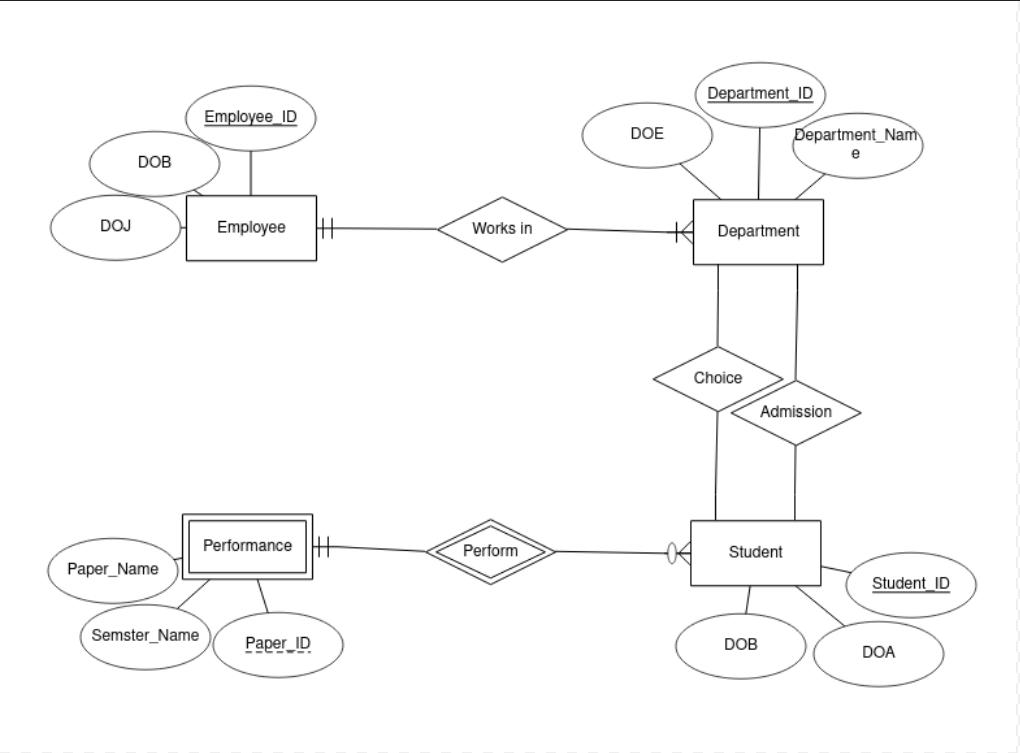

<h2 style="color:#069974">Schema: </h2>

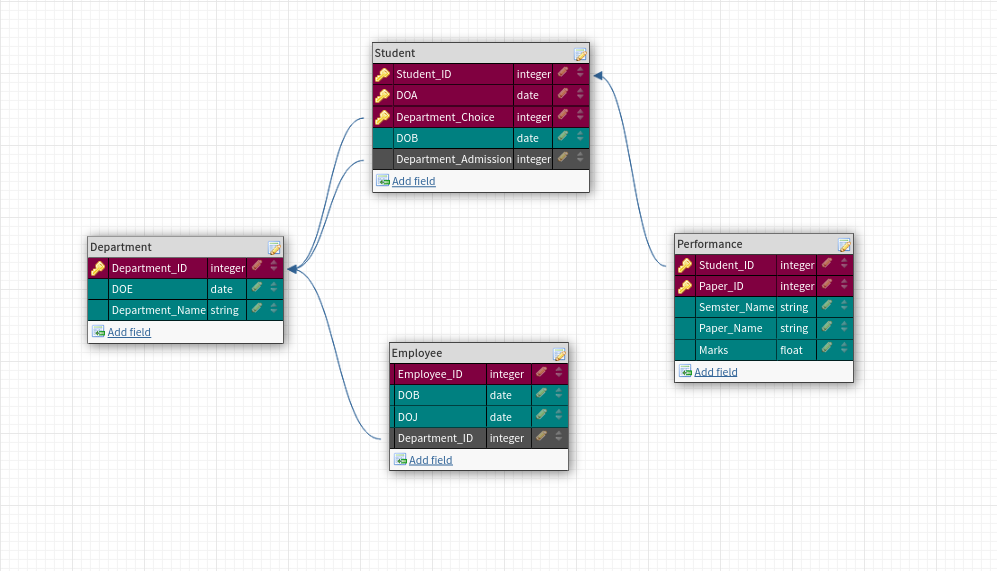

### <font color='#069974'>Here, </font>I will join all tables together to have my data together in one table

In [8]:
Fact_table = pd.merge(left=student, right=performance_WideVersion, on='Student_ID', how='inner')

Fact_table = pd.merge(left=Fact_table, right=department[['Department_ID', 'Department_Name']], left_on='Department_Choices', right_on='Department_ID', how='inner')
Fact_table.rename(columns={'Department_Name':'Department_Choices_Name'}, inplace=True)
Fact_table.drop(['Department_ID'], axis=1, inplace=True)
Fact_table.drop_duplicates(inplace=True)

Fact_table = pd.merge(left=Fact_table, right=department, left_on='Department_Admission', right_on='Department_ID', how='inner')
Fact_table.rename(columns={'Department_Name':'Department_Admission_Name'}, inplace=True)
Fact_table.drop(['Department_ID', 'DOE'], axis=1, inplace=True)
Fact_table.drop_duplicates(inplace=True)

In [9]:
display(Fact_table.head(5))
print(SEPARATOR)

display(Fact_table.describe(include='object'))
print(SEPARATOR)

display(Fact_table.describe())
print(SEPARATOR)

display(Fact_table.info())
print(SEPARATOR)

gc.collect()

,Student_ID,DOA,DOB,Department_Choices,Department_Admission,Semster_Name,Paper 1,Paper 2,Paper 3,Paper 4,Paper 5,Paper 6,Paper 7,Department_Choices_Name,Department_Admission_Name
0,SID20131143,2013-07-01 00:00:00,1996-02-05 00:00:00,IDEPT7783,IDEPT7783,Sem_1,44.0,74.0,80.0,44.0,95.0,61.0,90.0,Centre for Distance Engineering Education Prog...,Centre for Distance Engineering Education Prog...
3,SID20131143,2013-07-01 00:00:00,1996-02-05 00:00:00,IDEPT7783,IDEPT7783,Sem_2,92.0,57.0,91.0,84.0,80.0,66.0,54.0,Centre for Distance Engineering Education Prog...,Centre for Distance Engineering Education Prog...
6,SID20131143,2013-07-01 00:00:00,1996-02-05 00:00:00,IDEPT7783,IDEPT7783,Sem_3,76.0,83.0,41.0,80.0,69.0,73.0,66.0,Centre for Distance Engineering Education Prog...,Centre for Distance Engineering Education Prog...
9,SID20131143,2013-07-01 00:00:00,1996-02-05 00:00:00,IDEPT7783,IDEPT7783,Sem_4,78.0,83.0,94.0,NaN,99.0,100.0,91.0,Centre for Distance Engineering Education Prog...,Centre for Distance Engineering Education Prog...
12,SID20131143,2013-07-01 00:00:00,1996-02-05 00:00:00,IDEPT7783,IDEPT7783,Sem_5,92.0,44.0,69.0,60.0,97.0,22.0,86.0,Centre for Distance Engineering Education Prog...,Centre for Distance Engineering Education Prog...


##########################################################################################


,Student_ID,DOA,DOB,Department_Choices,Department_Admission,Semster_Name,Department_Choices_Name,Department_Admission_Name
count,95904,95904,95904,95904,95904,95904,95904,95904
unique,3819,18,5394,40,40,8,40,40
top,SID20162976,2015-07-01T00:00:00Z,1997-05-21,IDEPT6347,IDEPT3115,Sem_1,Sophisticated Analytical Instrument Facility (...,Chemical Engineering
freq,72,5528,72,2832,2976,11988,2832,2976


##########################################################################################


,Paper 1,Paper 2,Paper 3,Paper 4,Paper 5,Paper 6,Paper 7
count,93852.000000,94056.000000,93981.000000,93999.000000,94005.000000,94110.000000,94038.000000
mean,69.597622,69.489538,69.636129,69.629432,69.561704,69.589863,69.518503
std,18.078469,18.099143,18.156679,18.104293,18.083514,18.101498,18.015409
min,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
25%,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,55.000000
50%,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
75%,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


##########################################################################################
<class 'pandas.core.frame.DataFrame'>
Int64Index: 95904 entries, 0 to 287709
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Student_ID                 95904 non-null  object 
 1   DOA                        95904 non-null  object 
 2   DOB                        95904 non-null  object 
 3   Department_Choices         95904 non-null  object 
 4   Department_Admission       95904 non-null  object 
 5   Semster_Name               95904 non-null  object 
 6   Paper 1                    93852 non-null  float64
 7   Paper 2                    94056 non-null  float64
 8   Paper 3                    93981 non-null  float64
 9   Paper 4                    93999 non-null  float64
 10  Paper 5                    94005 non-null  float64
 11  Paper 6                    94110 non-null  float64
 12  Paper 7   

None

##########################################################################################


0

<h2 style="color:#069974">Note:</h2> 

#### 1. There are some students have up to `72 rows` in this data, this may because of there is many duplicates in some columns with different representations (Same value different representations).

<a id='trasforming'></a>
<h1 style="text-align:left; background-color:#246361; color:#DDDBC0; padding:14px; border-radius:10px; margin:15px">
    4 <font color='#2F4240'><strong>|</strong> </font>Data Transfoming</h1>

<a id='nulls'></a>
<h2 style="color:#069974">Transform Date columns to the same format: </h2>

In [10]:
Fact_table['DOA'] = pd.to_datetime(Fact_table['DOA'])
Fact_table['DOB'] = pd.to_datetime(Fact_table['DOB'])

Fact_table = Fact_table.drop_duplicates()

<a id='nulls'></a>
<h2 style="color:#069974">Handle Nulls: </h2>


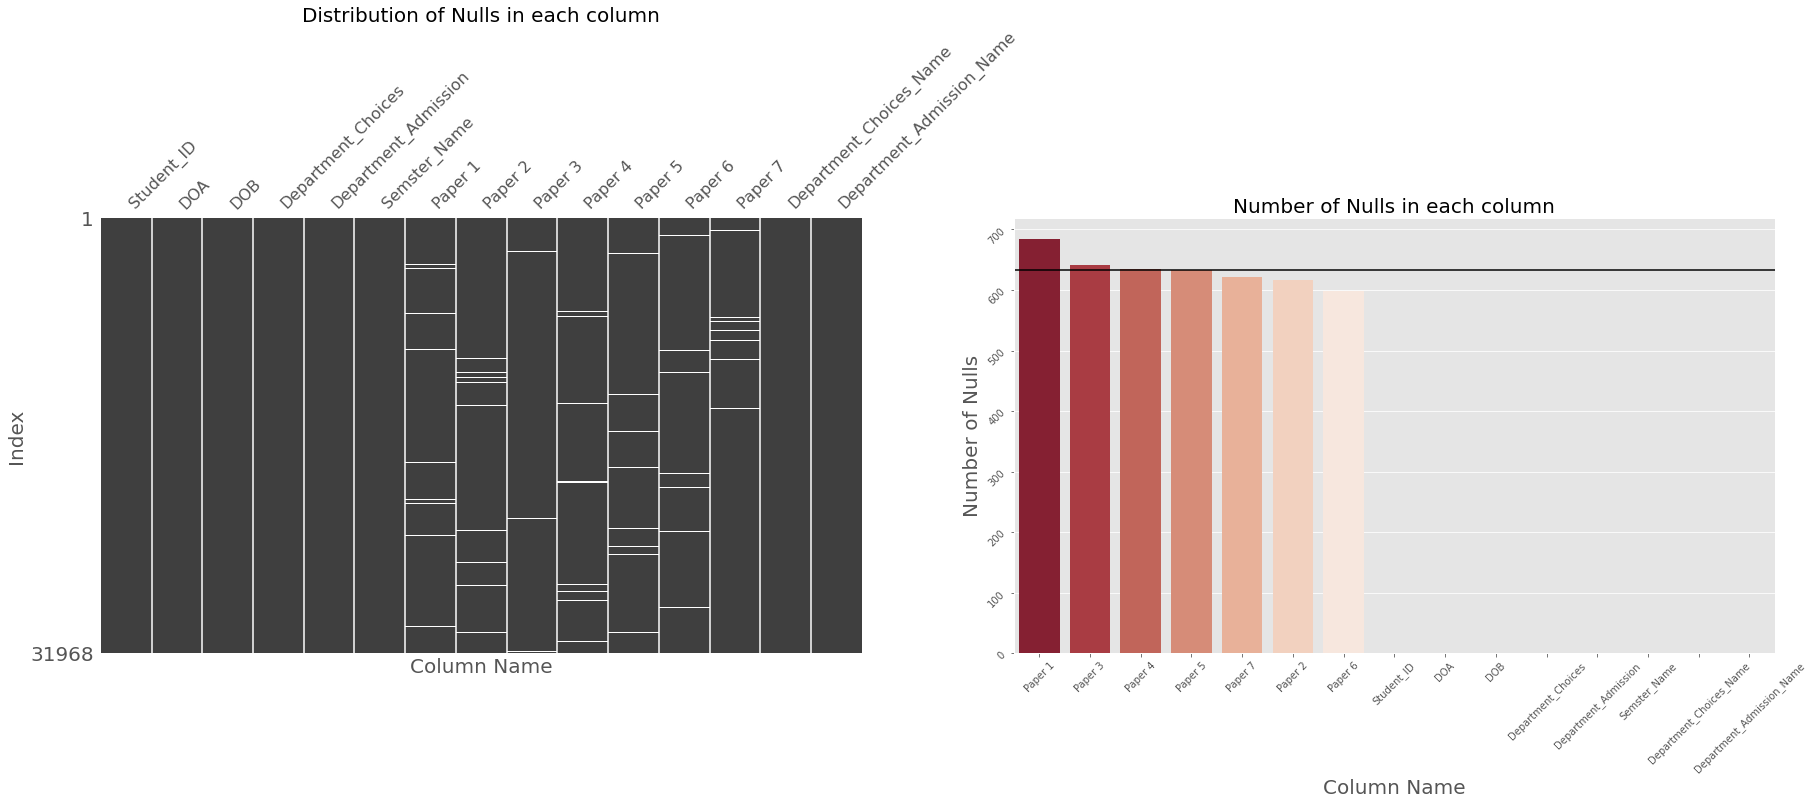

In [11]:
Nulls = Fact_table.isnull().sum().sort_values(ascending=False)
median = np.median(Nulls[Nulls>0].values)

fig, axs = plt.subplots(1, 2, figsize=(30, 8))
missingno.matrix(Fact_table, ax=axs[0])
axs[0].set_title('Distribution of Nulls in each column', size=20);axs[0].set_xlabel('Column Name', size=20);axs[0].set_ylabel('Index', size=20);

sns.barplot(x=Nulls.index, y=Nulls.values, ax=axs[1], palette='RdBu')
axs[1].tick_params(labelrotation=45)
axs[1].axhline(median, color='#000000')
axs[1].set_title('Number of Nulls in each column', size=20);axs[1].set_xlabel('Column Name', size=20);axs[1].set_ylabel('Number of Nulls', size=20);

Fact_table = Fact_table.dropna()

### There are relatively few nulls in our dataset approximately `13.8 %` rows have nulls, So we can just drop them without decreasing our data quality

<a id='outliers'></a>
<h2 style="color:#069974">Outliers: </h2>

In [12]:
fig = make_subplots(4, 2, subplot_titles=['Paper ' + str(i+1) for i in range(7)])

for i in range(7):
    trace = go.Histogram(x=Fact_table['Paper ' + str(i+1)], opacity=0.6)
    fig.add_trace(trace, row=i//2+1, col=i%2+1)

fig.update_traces(marker_line_width=1,marker_line_color="black")
fig.show()

<h2 style="color:#069974">Note:</h2> 

#### There are few marks below 30, then most marks starts from 40 to 100, So I will drop marks less than 40 and focus only on major marks (from 40 to 100).

In [13]:
for i in range(7):
    idx = Fact_table[Fact_table['Paper ' + str(i+1)]<=30].index
    Fact_table = Fact_table.drop(idx, axis=0)
    
fig = make_subplots(4, 2, subplot_titles=['Paper ' + str(i+1) for i in range(7)])

for i in range(7):
    trace = go.Histogram(x=Fact_table['Paper ' + str(i+1)], opacity=0.6)
    fig.add_trace(trace, row=i//2+1, col=i%2+1)

fig.update_traces(marker_line_width=1,marker_line_color="black")
fig.show()

print("Shape of Data after prerpocessing: ", Fact_table.shape)

gc.collect()

Shape of Data after prerpocessing:  (25870, 15)


805

<a id='EDA'></a>
<h1 style="text-align:left; background-color:#246361; color:#DDDBC0; padding:14px; border-radius:10px; margin:15px;">
    5 <font color='#2F4240'><strong>|</strong> </font>Exploratory Data Analysis</h1>

<a id=1></a>
<h2 style="color:#069974">Show any student's performance over all semsters</h2>

In [14]:
t = widgets.Text(value='SID20131143', placeholder='Enter Student\'s ID', description='Student ID')
Select_paper = widgets.Dropdown(options = ['Sum', 'Paper 1', 'Paper 2', 'Paper 3', 'Paper 4', 'Paper 5', 'Paper 6', 'Paper 7', 'All_together'], description='Marks: ', value='Paper 1')
display(t)
Select_paper

Text(value='SID20131143', description='Student ID', placeholder="Enter Student's ID")

Dropdown(description='Marks: ', index=1, options=('Sum', 'Paper 1', 'Paper 2', 'Paper 3', 'Paper 4', 'Paper 5'…

In [15]:
colors = ['red', 'green']
st_id = t.value
st_data = Fact_table[Fact_table['Student_ID']==t.value].reset_index(drop=True)
st_data['diff'] = 0

if Select_paper.value == "Sum":
    
    st_data['Sum'] = st_data.filter(regex='Paper').sum(axis=1)
    
    for i in range(1, len(st_data)):
        st_data.loc[i, 'diff'] = st_data.iloc[i]['Sum'] - st_data.iloc[i-1]['Sum']
    fig = go.Figure(go.Scatter(x=st_data["Semster_Name"], y=st_data['Sum'], mode='lines', text=st_data['diff']))
    
    fig.add_annotation(x=4, y=st_data[Select_paper.value].max()*1.1,
                       text=f"Total difference in marks over all semsters: {st_data['diff'].sum()}",
                       showarrow=False, font={'size':20., 'color':colors[st_data['diff'].sum()>0]})
    
    fig.update_layout({'xaxis': {'title': {'text':"Semster", 'font': {'size':20}}},
                       'yaxis': {'title': {'text':"Mark", 'font': {'size':20}}}, 
                       'title': {'text':Select_paper.value, 'font':{'size':20}}})
        
    
elif Select_paper.value == 'All_together':
    fig = go.Figure()
    for j in range(7):
        trace = go.Scatter(x=st_data["Semster_Name"], y=st_data["Paper " + str(j+1)], name=f"Paper {j+1}" )
        fig.add_trace(trace)
    fig.update_layout({'xaxis': {'title': {'text':"Semster", 'font': {'size':20}}},
                       'yaxis': {'title': {'text':"Mark", 'font': {'size':20}}}, 
                       'title': {'text':Select_paper.value, 'font':{'size':20}}})
    
else: 
    for i in range(1, len(st_data)):
        st_data.loc[i, 'diff'] = st_data.iloc[i][Select_paper.value] - st_data.iloc[i-1][Select_paper.value]

    fig = go.Figure(go.Scatter(x=st_data["Semster_Name"], y=st_data[Select_paper.value], text=st_data['diff']))
    
    fig.update_layout({'xaxis': {'title': {'text':"Semster", 'font': {'size':20}}},
                       'yaxis': {'title': {'text':"Mark", 'font': {'size':20}}}, 
                       'title': {'text':Select_paper.value, 'font':{'size':20}}})
    
    fig.add_annotation(x=4, y=st_data[Select_paper.value].max()*1.1, text=f"Total difference in {Select_paper.value} over all semsters: {st_data['diff'].sum()}", showarrow=False, font={'size':20., 'color':colors[st_data['diff'].sum()>0]})
    
fig.show()

semsterssemsters<a id=2></a>
<h2 style="color:#069974">Which is the semster that have the largest marks average?</h2>

In [16]:
marks_semster = Fact_table.groupby('Semster_Name').mean().mean(axis=1).sort_values(ascending=False)
px.bar(x=marks_semster.values, y=marks_semster.index, orientation='h', color=marks_semster.values, color_continuous_scale='RdBu')

<h2 style="color:#069974">Intuitions: </h2>

<font size=3>
    
* There are no much difference between marks in different semsters.
</font>

<a id=3></a>
<h2 style="color:#069974">Is there some papers more to related to each other?</h2>

In [17]:
corr = Fact_table.corr()
fig = px.imshow(corr, color_continuous_scale='balance', zmin=-1, zmax=1)
fig.update_traces(texttemplate="%{text}", text=corr.round(2))
fig.update_layout(height=720)
fig.show()

<h2 style="color:#069974">Intuitions: </h2>

<font size=3>
    
* There aren't much correlation between papers.
</font>

<a id=4></a>
<h2 style="color:#069974">Which are the top 10 attractive departments?</h2>

In [18]:
N = widgets.Text(value='10', placeholder='Number of departmnets', description='N: ')
Select_paper2 = widgets.Dropdown(options = ['Sum', 'Paper 1', 'Paper 2', 'Paper 3', 'Paper 4', 'Paper 5', 'Paper 6', 'Paper 7', 'All_together'],
                                 description='Marks: ', value='Paper 1')

DOB = np.unique(Fact_table['DOB'].sort_values())
slider = widgets.SelectionRangeSlider(options=DOB, description='Date: ', value=(pd.Timestamp('1995-07-07 00:00:00+0000', tz='UTC'),
 pd.Timestamp('1999-02-15 00:00:00+0000', tz='UTC')),
                                      layout={'width': '640px'})

display(N, slider)

Text(value='10', description='N: ', placeholder='Number of departmnets')

SelectionRangeSlider(description='Date: ', index=(0, 1088), layout=Layout(width='640px'), options=(Timestamp('…

In [19]:
date = slider.value
n = int(N.value)
S = Select_paper2.value

# extract data of given range date
filter1 = Fact_table.loc[((Fact_table['DOB'] >= date[0]).values & (Fact_table['DOB'] <= date[1]).values)]
 
top_attractive_departments = filter1['Department_Choices_Name'].value_counts()[:n].sort_values()

trace1 = go.Bar(x=top_attractive_departments.values,
                y=top_attractive_departments.index, orientation='h',
                name=f'Top {n} attractive departments')

fig = go.Figure(trace1)
fig.update_layout(dict(xaxis={'title':{'text':"Number of applied students", 'font':{'size':20}}},
                       yaxis={'title':{'text':"Department", 'font':{'size':20}}}))

<a id=8></a>
<h2 style="color:#069974">Distribution of students in each department</h2>

In [20]:
d = Fact_table.groupby('Department_Admission').count()
d['Department_Admission'] = d.index
fig = px.treemap(data_frame=d, values='Student_ID', path=['Department_Admission'], color='Student_ID', color_continuous_scale='deep')

fig.update_layout(title={'text':"Number of students addmitted in each department", 'font':{'size':20}})

<a id=5></a>
<h2 style="color:#069974">Does number of students in department depend on average marks of these students?</h2>

In [21]:
dept_choice_paper = pd.pivot_table(data=Fact_table, index='Department_Choices_Name', values=['Paper ' + str(i) for i in range(1, 8)], aggfunc=['mean', 'count'])
top_n = dept_choice_paper['count']['Paper 1'].sort_values(ascending=False)[:n]
dept_choice_paper = dept_choice_paper.loc[top_n.index]

fig = px.bar(x=dept_choice_paper['mean'].mean(axis=1), y=dept_choice_paper.index, orientation='h', color=dept_choice_paper['count']['Paper 1'], color_continuous_scale='RdBu')
fig.update_layout(title={'text':""}, 
                  xaxis={'title':"Marks"}, 
                  yaxis={'title':"Department Name"})

<h2 style="color:#069974">Intuitions: </h2>

<font size=3>
    
* It looks that number of sutdents in each department is independent on marks of these students where:
    * Climate Studies: has the least number of students 733. Howeve, average marks of joined students is relatively low 69.732.
    * Earth Science: is the second largest department in terms of student's count, Although average marks of joined students is relatively high 70.2.
    * CASDE: have few students and their marks are low.
    * SAIF: have largest number of students and its students have the largest marks. </font>

</font>
    



<a id=6></a>
<h2 style="color:#069974">Does some departments are more similiar to each others than others?</h2>

In [22]:
def abbreviation(full_name, threshold=20):
    abb = full_name.split('(')[-1].replace(')', '')
    if len(abb.split(' '))>1 and len(full_name)>threshold:
        abb = ''.join(map(lambda s : s[:2].title() if s!='and' else '&' , abb.split(' ')))
    return abb

f = Fact_table.groupby('Department_Choices_Name').mean().filter(regex='Paper')
f.index = f.index.values

abbreviations = [*map(abbreviation, f.index)]

fig = ff.create_dendrogram(f, labels=abbreviations, color_threshold=3)
fig.update_layout(height=640, width=1440, 
                  xaxis={'title':"Department_Name",})

fig.show()

<h2 style="color:#069974">Intuitions: </h2>

<font size=3>
    We can group departments in <strong>7 clusters</strong> corresponding to <strong>threshold=3</strong> (each cluster have a color)
</font>

<a id=7></a>
<h2 style="color:#069974">Time Series Analysis</h2>

In [23]:
# time series analysis
time_series = Fact_table.copy().sort_values(by='DOB')
time_series = time_series.groupby('DOB').mean()


time_series['year'] = pd.to_datetime(time_series.index).year
time_series['month'] = pd.to_datetime(time_series.index).month
time_series['marks'] = time_series.filter(regex='Paper').sum(axis=1)
fig = px.line(x=time_series.index, y=time_series['marks'], animation_frame=time_series['year'])
fig['layout'].pop('updatemenus')
fig.show()
gc.collect()

2475

<a id='FEFEFE'></a>
<h1 style="text-align:left; background-color:#246361; color:#DDDBC0; padding:14px; border-radius:10px; margin:15px">
    6 <font color='#2F4240'><strong>|</strong> </font>Feature Engineering</h1>

<h2 style="color:#069974">TODO: </h2>
 
In this Notebook, I am going to predict total marks of student in all papers given some information: 

1. His `Age`.
2. `is_accepted`: Is student accpeted in Department he chose.
3. `dept_choices_count`: Number of departments this student chose.
4. `year` and `month` of admission
5. `Semster_Name`.
6. `Department_Choices`.
7. `Department_Admission`.

In [24]:
def Feature_Engineering(df):
    
    # First calculate Age
    current_year = int(time.strftime('%Y'))
    df['Age'] = Fact_table['DOB'].apply(lambda d : current_year - d.year)
    
    # is_accepted column -> if student get admitted in his chosen department
    df['is_accepted'] = (df['Department_Choices']==df['Department_Admission']).astype('int')
    
    # count of department this student chose
    st_cnt = df.groupby(['Student_ID'])['Department_Choices'].nunique()
    df['dept_choices_count'] = Fact_table['Student_ID'].apply(lambda id : st_cnt[id])
    
    # month of admission
    df['admission_month'] = df['DOA'].dt.month
    
    # year of admission
    df['admission_year'] = df['DOA'].dt.year
    
    # One hot encode Semster_Name to 7 (n-1) columns
    semster_ohe = OneHotEncoder(drop='first')
    semster_matrix = semster_ohe.fit_transform(df['Semster_Name'].values.reshape(-1, 1)).toarray()
    df = pd.concat([df, pd.DataFrame(semster_matrix, index=df.index, columns=[f'semster {i}' for i in range(7)])], axis=1)
    
    # encode departments IDs in seven clusters
    agnes = AgglomerativeClustering(n_clusters=7, linkage='ward')
    labels = agnes.fit_predict(f)
    department_cluster = dict(zip(f.index, labels))
    
    df['Deptartment_Choices_cluster'] = df['Department_Choices_Name'].apply(lambda id : department_cluster[id])
    df['Department_Admission_cluster'] = df['Department_Admission_Name'].apply(lambda id : department_cluster[id])
    department_ohe = OneHotEncoder(drop='first')
    choice_matrix = department_ohe.fit_transform(df['Deptartment_Choices_cluster'].values.reshape(-1, 1)).toarray()
    admission_matrix = department_ohe.transform(df['Department_Admission_cluster'].values.reshape(-1, 1)).toarray()

    df = pd.concat([df, pd.DataFrame(admission_matrix, index=df.index, columns=[f'admission {i}' for i in range(6)])], axis=1)
    df = pd.concat([df, pd.DataFrame(choice_matrix, index=df.index, columns=[f'choice {i}' for i in range(6)])], axis=1)
    
    # drop not used columns
    df.drop(['Student_ID', 'DOA', 'DOB', 'Department_Choices', 'Semster_Name',
             'Department_Admission', 'Department_Choices_Name', 'Department_Admission_Name', 
             'Deptartment_Choices_cluster', 'Department_Admission_cluster'] + [f'Paper {i}' for i in range(1, 8)], 
            axis=1, inplace=True)
    
    return df
gc.collect()

0

<a id='modeling'></a>
<h1 style="text-align:left; background-color:#246361; color:#DDDBC0; padding:14px; border-radius:10px; margin:15px">
    7 <font color='#2F4240'><strong>|</strong> </font>Model Training</h1>

<font size=3>I have a considerable amaount of data that enables me to train a simple deep learning model.</font>

In [25]:
class UniversityDataLoader():
    
    def __init__(self, df):
        self.df = df
        self.X = Feature_Engineering(Fact_table)
        self.y = df.filter(regex='Paper').sum(axis=1)
        self.in_shape = self.X.shape
        self.traget_shape = self.y.shape
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor): # if we need to retrieve row using Tensor
            idx = idx.tolist()
        X = torch.Tensor(self.X.iloc[idx].values, device=DEVICE)
        
        return [X.float(), np.float32(self.y.iloc[idx])]

# Split train, validation and test data
dataloader = UniversityDataLoader(Fact_table)
train_size = int(0.85 * dataloader.in_shape[0])
test_size = dataloader.in_shape[0] - train_size
val_size = dataloader.in_shape[0] - train_size

trainloader, testloader = random_split(dataloader, [train_size, test_size])
trainloader, valloader = random_split(trainloader, [train_size-val_size, val_size])

trainloader = DataLoader(trainloader, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testloader, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valloader, batch_size=BATCH_SIZE, shuffle=True)

In [26]:
class Model(nn.Module):
    
    def block(self, in_shape, out_shape):
        seq = nn.Sequential(
                nn.Linear(in_features=in_shape, out_features=out_shape, device=DEVICE), 
                nn.BatchNorm1d(out_shape),
                self.act,
                self.DO
                )
        return seq
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.act = nn.ReLU()
        self.DO = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(24, 18)
        self.bn1 = nn.BatchNorm1d(18)
        
        self.fc2 = nn.Linear(18, 12)
        self.bn2 = nn.BatchNorm1d(12)
        
        self.fc3 = nn.Linear(12, 8)
        self.bn3 = nn.BatchNorm1d(8)
        
        self.fc4 = nn.Linear(8, 4)
        self.bn4 = nn.BatchNorm1d(4)
        
        self.fc5 = nn.Linear(4, 1)

    # Architecture: (24 -> 18 -> 12 -> 8 -> 4 -> 1).
    def forward(self, Input):
        # block1 (24, 18)
        data = self.fc1(Input)
        data = self.bn1(data)
        data = self.act(data)
        
        # block 2 (18 -> 12)
        data = self.fc2(data)
        data = self.bn2(data)
        data = self.act(data)
        data = self.DO(data)
        
        # block2 3 (12 -> 8)
        data = self.fc3(data)
        data = self.bn3(data)
        data = self.act(data)
        data = nn.Dropout(0.1)(data)
        
        # block 4 (8 -> 4)
        data = self.fc4(data)
        data = self.bn4(data)
        data = self.act(data)
        
        # block 3 (12 -> 1)
        data = self.fc5(data)
        return data
        


torch_model = Model()

val_loss = []
train_loss = []

def pytorch_train(EPOCHS, lr=1e-1, weight_decay=1e-1):
    
    loss_criteria = nn.MSELoss()
    optimizer = torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in tqdm(range(EPOCHS)):

        # Start epoch
        print(f"[INFO]: Epoch {epoch+1}: ")
        train_l = 0
        for i, (Input, label) in enumerate(trainloader):

            Input, label = Input.to(DEVICE).view(-1, 24), label.to(DEVICE)
            optimizer.zero_grad()

            # Forward propagation
            out = torch_model.forward(Input.float())

            # calculate gradients
            loss = loss_criteria(out, label)
            loss.backward()

            # update parameters
            optimizer.step()

            # eval model (with train)
            label = label.detach().numpy()
            out = out.detach().numpy()
            train_l += mean_squared_error(out, label)

        train_loss.append(train_l / i)


        # Evaluation
        val_l = 0
        for j, (X_val, y_val) in enumerate(valloader):

            y_pred = torch_model.forward(X_val)
            y_pred = y_pred.detach().numpy()
            y_val = y_val.detach().numpy()
            val_l += mean_squared_error(y_pred, y_val)

        val_loss.append(val_l / j)
        print(f"Train Mean Square Error = {train_loss[-1]}")
        print(f"Val Mean Square Error = {val_loss[-1]}")
        
print(SEPARATOR)
pytorch_train(EPOCHS=EPOCHS[0], lr=LRSchedules[0])
print(SEPARATOR)
pytorch_train(EPOCHS=EPOCHS[1], lr=LRSchedules[1])
print(SEPARATOR)

##########################################################################################


  0%|          | 0/30 [00:00<?, ?it/s]

[INFO]: Epoch 1: 


  3%|▎         | 1/30 [00:04<02:10,  4.51s/it]

Train Mean Square Error = 19635.88981292941
Val Mean Square Error = 2495.308447265625
[INFO]: Epoch 2: 


  7%|▋         | 2/30 [00:08<02:04,  4.44s/it]

Train Mean Square Error = 2504.777683122784
Val Mean Square Error = 2482.4009358723956
[INFO]: Epoch 3: 


 10%|█         | 3/30 [00:13<01:59,  4.42s/it]

Train Mean Square Error = 2485.822400681516
Val Mean Square Error = 2526.4103841145834
[INFO]: Epoch 4: 


 13%|█▎        | 4/30 [00:17<01:55,  4.43s/it]

Train Mean Square Error = 2295.0093898908467
Val Mean Square Error = 2379.4991536458333
[INFO]: Epoch 5: 


 17%|█▋        | 5/30 [00:22<01:52,  4.49s/it]

Train Mean Square Error = 2285.296489742631
Val Mean Square Error = 2306.1954711914063
[INFO]: Epoch 6: 


 20%|██        | 6/30 [00:26<01:47,  4.46s/it]

Train Mean Square Error = 2261.0592318054632
Val Mean Square Error = 2311.2904296875
[INFO]: Epoch 7: 


 23%|██▎       | 7/30 [00:31<01:42,  4.44s/it]

Train Mean Square Error = 2243.655558268229
Val Mean Square Error = 2263.649043782552
[INFO]: Epoch 8: 


 27%|██▋       | 8/30 [00:35<01:37,  4.44s/it]

Train Mean Square Error = 2297.9998874529033
Val Mean Square Error = 2344.6315022786457
[INFO]: Epoch 9: 


 30%|███       | 9/30 [00:39<01:33,  4.43s/it]

Train Mean Square Error = 2273.9750993877437
Val Mean Square Error = 2299.7219482421874
[INFO]: Epoch 10: 


 33%|███▎      | 10/30 [00:44<01:28,  4.43s/it]

Train Mean Square Error = 2287.4168450105276
Val Mean Square Error = 2291.635636393229
[INFO]: Epoch 11: 


 37%|███▋      | 11/30 [00:48<01:23,  4.42s/it]

Train Mean Square Error = 2289.871648693761
Val Mean Square Error = 2299.614217122396
[INFO]: Epoch 12: 


 40%|████      | 12/30 [00:53<01:21,  4.55s/it]

Train Mean Square Error = 2300.607028825909
Val Mean Square Error = 2651.2813639322917
[INFO]: Epoch 13: 


 43%|████▎     | 13/30 [00:58<01:17,  4.55s/it]

Train Mean Square Error = 2270.904093424479
Val Mean Square Error = 2295.523164876302
[INFO]: Epoch 14: 


 47%|████▋     | 14/30 [01:02<01:12,  4.53s/it]

Train Mean Square Error = 2282.3537563026375
Val Mean Square Error = 2297.300459798177
[INFO]: Epoch 15: 


 50%|█████     | 15/30 [01:07<01:07,  4.50s/it]

Train Mean Square Error = 2247.7490450811724
Val Mean Square Error = 2325.7183471679687
[INFO]: Epoch 16: 


 53%|█████▎    | 16/30 [01:11<01:02,  4.47s/it]

Train Mean Square Error = 2269.4266028438055
Val Mean Square Error = 2311.5499186197917
[INFO]: Epoch 17: 


 57%|█████▋    | 17/30 [01:15<00:58,  4.47s/it]

Train Mean Square Error = 2257.7253660377883
Val Mean Square Error = 2311.5689412434895
[INFO]: Epoch 18: 


 60%|██████    | 18/30 [01:20<00:53,  4.46s/it]

Train Mean Square Error = 2295.8679078014184
Val Mean Square Error = 2298.788464355469
[INFO]: Epoch 19: 


 63%|██████▎   | 19/30 [01:24<00:49,  4.48s/it]

Train Mean Square Error = 2253.5069943691824
Val Mean Square Error = 2341.416707356771
[INFO]: Epoch 20: 


 67%|██████▋   | 20/30 [01:29<00:44,  4.50s/it]

Train Mean Square Error = 2259.5375266650044
Val Mean Square Error = 2305.1281616210936
[INFO]: Epoch 21: 


 70%|███████   | 21/30 [01:33<00:40,  4.49s/it]

Train Mean Square Error = 2291.077998600953
Val Mean Square Error = 2294.794930013021
[INFO]: Epoch 22: 


 73%|███████▎  | 22/30 [01:38<00:35,  4.49s/it]

Train Mean Square Error = 2286.367272343196
Val Mean Square Error = 2331.999861653646
[INFO]: Epoch 23: 


 77%|███████▋  | 23/30 [01:42<00:31,  4.47s/it]

Train Mean Square Error = 2262.3173100897607
Val Mean Square Error = 2316.241133626302
[INFO]: Epoch 24: 


 80%|████████  | 24/30 [01:47<00:26,  4.44s/it]

Train Mean Square Error = 2258.4394643797095
Val Mean Square Error = 2488.266495768229
[INFO]: Epoch 25: 


 83%|████████▎ | 25/30 [01:51<00:22,  4.47s/it]

Train Mean Square Error = 2273.8355963957224
Val Mean Square Error = 2297.320279947917
[INFO]: Epoch 26: 


 87%|████████▋ | 26/30 [01:56<00:18,  4.53s/it]

Train Mean Square Error = 2249.4377666500445
Val Mean Square Error = 2293.538232421875
[INFO]: Epoch 27: 


 90%|█████████ | 27/30 [02:01<00:13,  4.53s/it]

Train Mean Square Error = 2300.9901452030695
Val Mean Square Error = 2300.0350667317707
[INFO]: Epoch 28: 


 93%|█████████▎| 28/30 [02:05<00:08,  4.48s/it]

Train Mean Square Error = 2254.350023202017
Val Mean Square Error = 2489.827197265625
[INFO]: Epoch 29: 


 97%|█████████▋| 29/30 [02:09<00:04,  4.46s/it]

Train Mean Square Error = 2262.98386161209
Val Mean Square Error = 2317.1994750976564
[INFO]: Epoch 30: 


100%|██████████| 30/30 [02:14<00:00,  4.48s/it]


Train Mean Square Error = 2253.803433032746
Val Mean Square Error = 2303.6803588867188
##########################################################################################


  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: Epoch 1: 


  5%|▌         | 1/20 [00:04<01:23,  4.40s/it]

Train Mean Square Error = 2219.2169553066824
Val Mean Square Error = 2292.068815104167
[INFO]: Epoch 2: 


 10%|█         | 2/20 [00:08<01:21,  4.51s/it]

Train Mean Square Error = 2217.723193878823
Val Mean Square Error = 2290.099617513021
[INFO]: Epoch 3: 


 15%|█▌        | 3/20 [00:13<01:15,  4.47s/it]

Train Mean Square Error = 2218.0002380803967
Val Mean Square Error = 2284.8580607096355
[INFO]: Epoch 4: 


 20%|██        | 4/20 [00:17<01:11,  4.45s/it]

Train Mean Square Error = 2221.7705788037456
Val Mean Square Error = 2294.375215657552
[INFO]: Epoch 5: 


 25%|██▌       | 5/20 [00:22<01:06,  4.44s/it]

Train Mean Square Error = 2222.555512556793
Val Mean Square Error = 2290.892451985677
[INFO]: Epoch 6: 


 30%|███       | 6/20 [00:26<01:01,  4.43s/it]

Train Mean Square Error = 2220.1011859000996
Val Mean Square Error = 2274.0522298177084
[INFO]: Epoch 7: 


 35%|███▌      | 7/20 [00:31<00:57,  4.43s/it]

Train Mean Square Error = 2219.7959382618574
Val Mean Square Error = 2331.6385416666667
[INFO]: Epoch 8: 


 40%|████      | 8/20 [00:35<00:53,  4.42s/it]

Train Mean Square Error = 2219.156805809508
Val Mean Square Error = 2303.0285074869794
[INFO]: Epoch 9: 


 45%|████▌     | 9/20 [00:40<00:49,  4.47s/it]

Train Mean Square Error = 2221.117960611979
Val Mean Square Error = 2277.215889485677
[INFO]: Epoch 10: 


 50%|█████     | 10/20 [00:44<00:44,  4.49s/it]

Train Mean Square Error = 2218.5716145833335
Val Mean Square Error = 2294.2059651692707
[INFO]: Epoch 11: 


 55%|█████▌    | 11/20 [00:49<00:40,  4.46s/it]

Train Mean Square Error = 2220.081214850676
Val Mean Square Error = 2286.561588541667
[INFO]: Epoch 12: 


 60%|██████    | 12/20 [00:53<00:35,  4.46s/it]

Train Mean Square Error = 2221.302490234375
Val Mean Square Error = 2286.0892537434897
[INFO]: Epoch 13: 


 65%|██████▌   | 13/20 [00:57<00:31,  4.45s/it]

Train Mean Square Error = 2220.3154071780805
Val Mean Square Error = 2270.388883463542
[INFO]: Epoch 14: 


 70%|███████   | 14/20 [01:02<00:26,  4.45s/it]

Train Mean Square Error = 2219.160208194814
Val Mean Square Error = 2285.001843261719
[INFO]: Epoch 15: 


 75%|███████▌  | 15/20 [01:06<00:22,  4.44s/it]

Train Mean Square Error = 2220.391779040614
Val Mean Square Error = 2300.176993815104
[INFO]: Epoch 16: 


 80%|████████  | 16/20 [01:11<00:17,  4.47s/it]

Train Mean Square Error = 2218.044820582613
Val Mean Square Error = 2278.6042683919272
[INFO]: Epoch 17: 


 85%|████████▌ | 17/20 [01:16<00:13,  4.55s/it]

Train Mean Square Error = 2219.944808635306
Val Mean Square Error = 2282.0155110677083
[INFO]: Epoch 18: 


 90%|█████████ | 18/20 [01:20<00:09,  4.53s/it]

Train Mean Square Error = 2220.17544360871
Val Mean Square Error = 2288.267887369792
[INFO]: Epoch 19: 


 95%|█████████▌| 19/20 [01:24<00:04,  4.50s/it]

Train Mean Square Error = 2218.5474697681184
Val Mean Square Error = 2290.1765869140627
[INFO]: Epoch 20: 


100%|██████████| 20/20 [01:29<00:00,  4.47s/it]

Train Mean Square Error = 2223.5917665738584
Val Mean Square Error = 2276.0523600260417
##########################################################################################


<a href="https://ibb.co/J58KXQj"><img src="https://i.ibb.co/cDR1zLh/university-1.png" alt="university-1" border="0"></a>

In [27]:
x = np.arange(len(train_loss))
trace3 = go.Scatter(x=x, y=train_loss, mode='lines+markers', name='train_loss')
trace4 = go.Scatter(x=x, y=val_loss, mode='lines+markers', name='val_loss')

fig = go.Figure([trace3, trace4])
fig.update_layout(font={'size':15}, 
                  xaxis={'title':"Epoch number"}, 
                  yaxis={'title':"Mean Sqaure Error"}, 
                  title={'text':"Training history"})

fig.add_annotation(x=EPOCHS[0], y=train_loss[EPOCHS[0]],
                   text=f"Last Epoch in process 1",
                   showarrow=True, xanchor='left', font={'size':15}, arrowhead=2)
fig.show()

In [28]:
def areaplot(y_true, y_pred):
    trace1 = go.Scatter(x=np.arange(len(y_true)), y=y_true, fill='tozeroy', name='True')
    trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred, fill='tozeroy', name='Predicted')
    fig = go.Figure([trace1, trace2])
    fig.update_layout(hovermode='x', 
                      xaxis={'title': "Number of record in sample"}, 
                      yaxis={'title': "Predicted - True"}, 
                      title={'text': "True vs Predicted values", 'font':{'size':15}}, 
                      font={'size':15})
    return fig

n_TestBatches = np.floor(((len(Fact_table) / BATCH_SIZE)*0.15))
sample = np.random.randint(0, n_TestBatches)
for _ in range(sample):
    data = iter(testloader).next()
    
X_test_sample, y_test_sample = data
y_pred = torch_model.forward(X_test_sample).detach().numpy()

print(F"Test Mean Square Error: {colored(mean_squared_error(y_test_sample, y_pred), 'red')}")
areaplot(y_test_sample, y_pred[:, 0])

Test Mean Square Error: 2080.195
